In [1]:
import driftmlp
from driftmlp.plotting.general import plot_stations
from driftmlp.drifter_indexing.discrete_system import h3_default
from driftmlp.plotting import make_gpd

import pickle
import pandas as pd
import numpy as np

from shapely.geometry import Point

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gc


import string
alphabet = string.ascii_lowercase

stations = np.loadtxt("locations.txt", delimiter=',')
stations = pd.DataFrame(stations, index=range(1, 8))
stations.columns = ['Longitude', 'Latitude']
### Loads in a list of 100 rotation networks 
if 'nets' not in globals(): 
    print('loading networks (slow)')
    nets = pickle.load(open('rotations_30_4_55.p', 'rb'))
    nets_append = pickle.load(open('rotations_30_4_10.p', 'rb'))
    nets = nets+nets_append
    print('finished_loading networks')
origins = [stations.iloc[i].loc[['Longitude', 'Latitude']].to_list() for i in range(stations.shape[0])]
plot_n=len(nets)

def path_and_df(network):
    discretizer = h3_default(res=4, rot=network['rotation'])
    try:
        indices = discretizer.return_inds(origins)
        paths = [driftmlp.shortest_path.get_all_paths(network, src, indices) for src in  indices]
    except:
        return None
    ##We didn't store all the gpd dataframes originally as its' costly memorywise
    rot = network['rotation']
    return {'paths':paths, 'discretizer':discretizer, 'rot':rot}
line_trans = 0.03
h3_sys = driftmlp.drifter_indexing.discrete_system.h3_default(res=4)
#For each path, obta
res = []
print("getting paths")
for i in range(plot_n):
    res.append(path_and_df(nets[i]))

loading networks (slow)
finished_loading networks
getting paths


(60, 7, 7)


0

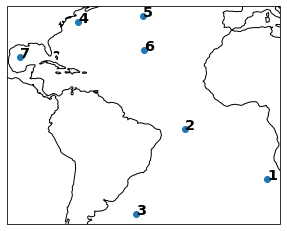

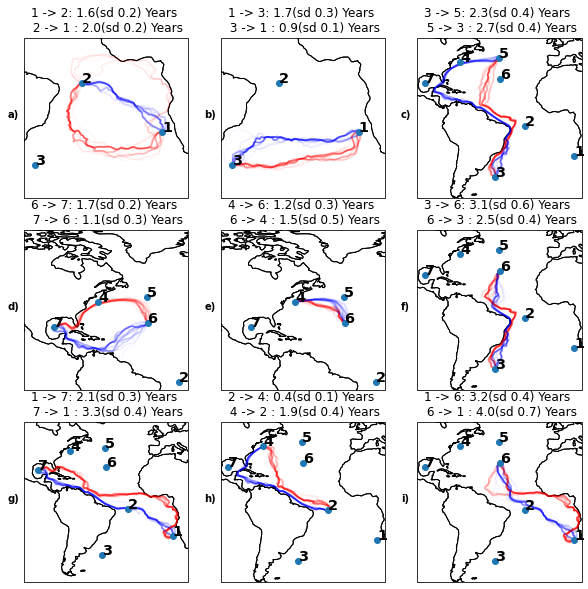

In [2]:

ax = plot_stations(stations, names= stations.index)
exts = [ax.get_extent(), [-50, 20, -40, 5], [-110, -20, 1, 60]]
which_ext = [1, 1, 0, 2, 2, 0, 0, 0, 0]
def plot_rotated_line(h3_gpd, h3_ids, ax, *args,**kwargs):
    h3_rot = h3_gpd.loc[h3_ids]
    driftmlp.plotting.h3_cartopy.plot_line(h3_rot, h3_ids,'centroid_col', ax=ax, fig_init=False, *args, **kwargs)

##Large figure
fig = plt.figure(figsize = (10,10))
def get_h3_inds_for_path(res_group):
    k = res_group['paths']
    discretizer = res_group['discretizer']
    all_inds = [ind for i in k for path in i for ind in path.h3id]
    
    gpd_df = make_gpd.list_to_multipolygon_df(all_inds, discretizer)
    return gpd_df
travel_times = np.array([
    [
            [path.travel_time for path in list_of_paths]
        for list_of_paths in res[i]['paths']]
    for i in range(len(res))])
##If this doesn't say n_rot, n_stations, n_stations fix it
print(travel_times.shape)
### Get the sample mean and std
mean_tts = travel_times.mean(axis=0)
var_tts = travel_times.var(axis=0,ddof=1)


ods = [[0, 1], [0, 2], [2, 4], [5, 6], [3, 5], [2, 5], [0, 6], [1, 3], [0, 5]]  
subplots_shape=(3,3)
for i in range(min(len(ods),9)):
    ## Make a new subplot and select current stations
    ax = plt.subplot(subplots_shape[0], subplots_shape[1], i+1, projection=ccrs.PlateCarree())
    from_st = ods[i][0]
    to_st = ods[i][1]
    for res_dict in res[:plot_n]:
        ##Plot the rotated lines both there and back
        h3_gpd = get_h3_inds_for_path(res_dict)
        plot_rotated_line(h3_gpd, 
                          res_dict['paths'][from_st][to_st].h3id,
                          ax,
                          alpha=line_trans, fl=False ,color='blue')
        plot_rotated_line(h3_gpd, 
                          res_dict['paths'][to_st][from_st].h3id,
                          ax,
                          alpha=line_trans, fl=False ,color='red')
        
    ## add stations to the plot, and set it the right extent to match figure 5
    driftmlp.plotting.general.plot_stations(stations, ax=ax, names=list(range(1,8)))
    ax.set_extent(exts[which_ext[i]])
    
    ## format the title.
    tt1 = mean_tts[ods[i][0], ods[i][1]]
    tt2 = mean_tts[ods[i][1], ods[i][0]]
    var1 = var_tts[from_st, to_st]
    var2 = var_tts[to_st, from_st]
    ax.set_title("{} -> {}: {}(sd {}) Years \n {} -> {} : {}(sd {}) Years".format(
        ods[i][0]+1, ods[i][1]+1, round(tt1/365,1), round(np.sqrt(var1)/365, 1),
       ods[i][1]+1, ods[i][0]+1, round(tt2/365,1), round(np.sqrt(var2)/365, 1)))
    plot_num = alphabet[i]
    ax.text(-0.1,0.5,"{})".format(plot_num),transform = ax.transAxes, fontweight='bold')
    ax.set_adjustable('datalim')

    ax.coastlines()
fig.savefig('Images/rotation_results.pdf', bbox_inches='tight')
fig.savefig('Images/rotation_results_res_4.png', bbox_inches='tight')
#del res
gc.collect()

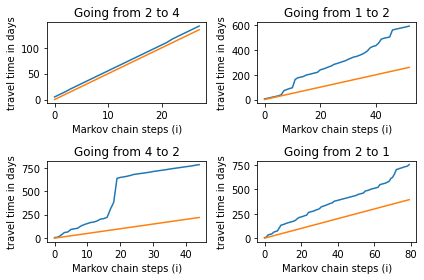

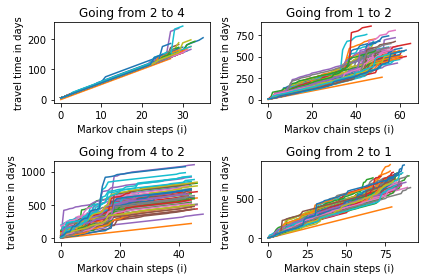

In [3]:
import seaborn as sns
fig,ax = plt.subplots(2,2)
def plot_data(od,ax, res_ind=0, plot_days = True):
    from_st, to_st = od

    data = res[res_ind]['paths'][from_st][to_st]
    plot_data= np.cumsum(data.travel_time_list)
    ax.plot(plot_data)
    if plot_days:
        days = [i*5 for i in range(len(plot_data))]
        ax.plot(days, label='y=5x')
    ax.set_title(f"Going from {od[0]+1} to {od[1]+1}")
    ax.set_ylabel("travel time in days")
    ax.set_xlabel("Markov chain steps (i)")
def plot_data_rot(od, ax):
    plot_data(od, ax=ax)
    for i in range(1,len(res)):
        plot_data(od, ax=ax, res_ind=i, plot_days=False)
plot_data(ods[7], ax=ax[0,0])
plot_data(ods[7][::-1], ax=ax[1,0])
plot_data(ods[0], ax=ax[0,1])
plot_data(ods[0][::-1], ax=ax[1,1])
fig.tight_layout()
plt.savefig("tt_working.pdf")
fig,ax = plt.subplots(2,2)
plot_data_rot(ods[7], ax=ax[0,0])
plot_data_rot(ods[7][::-1], ax=ax[1,0])
plot_data_rot(ods[0], ax=ax[0,1])
plot_data_rot(ods[0][::-1], ax=ax[1,1])
fig.tight_layout()
plt.savefig("tt_working_rot.pdf")

In [4]:
def get_non_zeros(arr):
    mask = arr!=0
    return arr[mask].flatten()
from scipy.stats import spearmanr, pearsonr
from matplotlib import rc
#rc('text', usetex=True)

In [5]:
non_zero_mean_tts = get_non_zeros(mean_tts)
non_zero_median_tts = get_non_zeros(np.median(travel_times, axis=0))
non_zero_tts = [get_non_zeros(travel_times[i, :,:]) for i in range(travel_times.shape[0])]
first_rot = get_non_zeros(non_zero_tts[0])
corrs_to_mean = [spearmanr(non_zero_mean_tts, non_zero_tt)[0] for non_zero_tt in non_zero_tts]

In [6]:
np.mean(corrs_to_mean)

0.9424598313610428

## Quickly inspect the correlation between Resolution 3 and Resolution 4
### Note this is using 100 rotations for resolution 3 and 60 rotations for resolution 4.

array([[   0.        ,  813.1069491 , 1484.20475653, 1084.66525388,
        1483.02218209, 1584.45137436, 1165.08620153],
       [1438.27165438,    0.        ,  684.9556903 ,  290.28538178,
         688.64230998,  811.20421196,  370.70632942],
       [ 854.12703211, 2237.86612409,    0.        , 2116.49994471,
        2514.85687291, 2694.1396113 , 2196.92089235],
       [3945.53101531, 2764.30733316, 3397.83777227,    0.        ,
        1632.08444334, 1968.85350561, 1482.57951583],
       [2856.66694248, 2390.92456401, 2867.3849274 , 1551.57306959,
           0.        ,  896.37900382, 1565.19095439],
       [2805.15004361, 1573.37781395, 2131.61078452, 1373.43217325,
         957.7108869 ,    0.        ,  973.44580698],
       [3906.95721907, 2851.31693219, 3473.76074199,  260.11569653,
         670.04887438,  983.41380673,    0.        ]])

SpearmanrResult(correlation=0.8026091888825865, pvalue=1.6319936358801487e-10)
SpearmanrResult(correlation=0.831942306134025, pvalue=8.730057097468329e-12)


Text(0, 0.5, 'Resolution 3 mean')

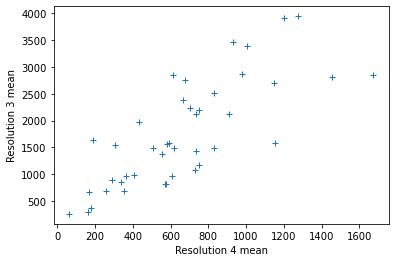

In [7]:
tt100_res3, tt100_median_res3 = pickle.load(open("100_rot.p",'rb'))
display(tt100_res3)
tt100_res3_non_zeros = get_non_zeros(tt100_res3)
print(spearmanr(non_zero_mean_tts, tt100_res3_non_zeros))
print(spearmanr(non_zero_mean_tts, get_non_zeros(tt100_median_res3)))
_, ax = plt.subplots()
ax.plot(non_zero_mean_tts, tt100_res3_non_zeros, '+')
ax.set_xlabel("Resolution 4 mean")
ax.set_ylabel("Resolution 3 mean")

In [8]:
corrs_to_first = [spearmanr(first_rot, non_zero_tt)[0] for non_zero_tt in non_zero_tts]

In [9]:
np.mean(corrs_to_first) ### Compare to .79 of res 3

0.9159274419951241

## Bootstrap

In [10]:
np.random.seed(55)
import os
file = os.environ['DRIFTFILE']

discretizer = h3_default(res=4)

if 'boot_paths' not in globals():
    boot_paths = pickle.load(open("boot_res_4_100.p", "rb"))
h3_gpd = driftmlp.plotting.make_gpd.full_multipolygon_df(discretizer)
h3_gpd.shape
all_ids = [i.h3id for res_dict in boot_paths for list_of_paths in res_dict['paths'] for i in list_of_paths]

(100, 7, 7)


5

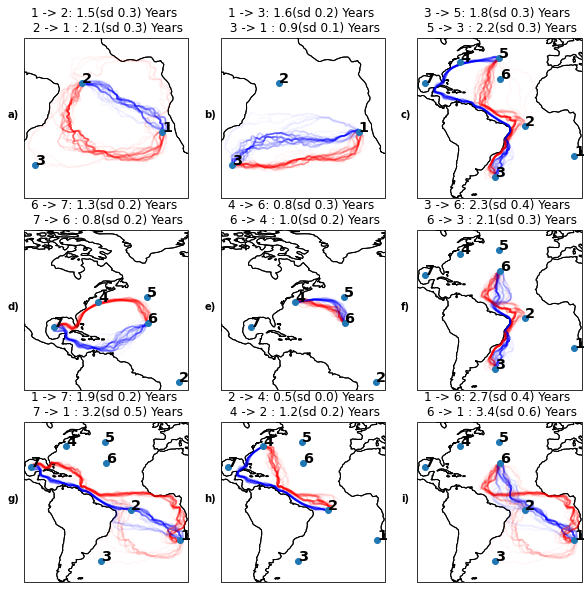

In [11]:
fig = plt.figure(figsize = (10,10))
travel_times = np.array([
            [
                [path.travel_time for path in list_of_paths]
        for list_of_paths in boot_paths[i]['paths']]
    for i in range(len(boot_paths))])
##If this doesn't say n_rot, n_stations, n_stations fix it
print(travel_times.shape)
### Get the sample mean and std
mean_tts_boot = travel_times.mean(axis=0)
var_tts_boot = travel_times.var(axis=0,ddof=1)


ods = [[0, 1], [0, 2], [2, 4], [5, 6], [3, 5], [2, 5], [0, 6], [1, 3], [0, 5]]  
subplots_shape=(3,3)
for i in range(min(len(ods),9)):
    ## Make a new subplot and select current stations
    ax = plt.subplot(subplots_shape[0], subplots_shape[1], i+1, projection=ccrs.PlateCarree())
    from_st = ods[i][0]
    to_st = ods[i][1]
    for res_dict in boot_paths:
        ##Plot the rotated lines both there and back
        
        plot_rotated_line(h3_gpd, 
                          res_dict['paths'][from_st][to_st].h3id,
                          ax,
                          alpha=line_trans, fl=False ,color='blue')
        plot_rotated_line(h3_gpd, 
                          res_dict['paths'][to_st][from_st].h3id,
                          ax,
                          alpha=line_trans, fl=False ,color='red')
        
    ## add stations to the plot, and set it the right extent to match figure 5
    driftmlp.plotting.general.plot_stations(stations, ax=ax, names=list(range(1,8)))
    ax.set_extent(exts[which_ext[i]])
    
    ## format the title.
    tt1 = mean_tts_boot[ods[i][0], ods[i][1]]
    tt2 = mean_tts_boot[ods[i][1], ods[i][0]]
    var1 = var_tts_boot[from_st, to_st]
    var2 = var_tts_boot[to_st, from_st]
    ax.set_title("{} -> {}: {}(sd {}) Years \n {} -> {} : {}(sd {}) Years".format(
        ods[i][0]+1, ods[i][1]+1, round(tt1/365,1), round(np.sqrt(var1)/365, 1),
       ods[i][1]+1, ods[i][0]+1, round(tt2/365,1), round(np.sqrt(var2)/365, 1)))
    plot_num = alphabet[i]
    ax.text(-0.1,0.5,"{})".format(plot_num),transform = ax.transAxes, fontweight='bold')
    ax.set_adjustable('datalim')

    ax.coastlines()

#fig.savefig('Images/rotation_results.pdf', bbox_inches='tight')
fig.savefig('Images/bootstrap_results_res_4.png', bbox_inches='tight')
#del res
gc.collect()

In [12]:
non_zero_mean_tts = get_non_zeros(mean_tts_boot)

non_zero_tts = [get_non_zeros(travel_times[i, :,:]) for i in range(travel_times.shape[0])]
first_boot = non_zero_tts[0]
corrs_to_mean = [spearmanr(non_zero_mean_tts, non_zero_tt)[0] for non_zero_tt in non_zero_tts]
np.mean(corrs_to_mean)
corrs_to_first = [spearmanr(first_boot, non_zero_tt)[0] for non_zero_tt in non_zero_tts]
print(np.mean(corrs_to_mean))
print(np.mean(corrs_to_first))

0.96218334247799
0.931797591474388
